# Phase 4: Pembuatan Dataset Final & Pelabelan

**Tujuan:** Tahap ini adalah jembatan antara rekayasa fitur dan pemodelan prediktif. Tujuannya adalah untuk menciptakan variabel target (`is_buzzer`) yang akan dipelajari oleh model machine learning kita. Karena kita tidak memiliki data "ground truth" (data yang sudah dilabeli oleh manusia), kita akan menggunakan **Heuristic Labeling**.

**Apa itu Heuristic Labeling?**
Ini adalah teknik di mana kita membuat serangkaian aturan logis berdasarkan pengetahuan domain untuk memberi label pada data. Aturan kita akan didasarkan pada kombinasi fitur-fitur ekstrem yang sangat kuat mengindikasikan perilaku non-organik.

**Langkah-langkah yang akan dilakukan:**
1.  **Load Final Features:** Memuat dataset `final_features.csv` dari Phase 3.
2.  **Define Heuristic Rules:** Menentukan kombinasi ambang batas (threshold) pada fitur-fitur kunci (misalnya, `in_degree` rendah, `out_degree` tinggi, `narrative_similarity` tinggi) untuk mendefinisikan "profil buzzer".
3.  **Apply Labels:** Menerapkan aturan tersebut untuk membuat kolom baru `is_buzzer` dengan nilai `1` (terindikasi buzzer) atau `0` (pengguna biasa).
4.  **Analyze and Save:** Menganalisis distribusi label yang dihasilkan dan menyimpan dataset final yang siap untuk dilatih.


### 4.1. Install & Import Requirements

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

### 4.2. Load Final Feature Set

Kita akan memuat `final_features.csv` yang merupakan output komprehensif dari Phase 3.


In [2]:
try:
    df_final = pd.read_csv('final_features.csv')
    print("✅ Dataset fitur final ('final_features.csv') berhasil dimuat.")
    print(f"Shape: {df_final.shape}")
    display(df_final.describe())

except FileNotFoundError:
    print("❌ ERROR: File 'final_features.csv' tidak ditemukan.")
    print("Pastikan Anda sudah menjalankan notebook Phase 3 terlebih dahulu.")
    df_final = pd.DataFrame()

✅ Dataset fitur final ('final_features.csv') berhasil dimuat.
Shape: (680, 9)


,community,pagerank,betweenness,in_degree,out_degree,narrative_similarity,tweet_frequency,reply_ratio
count,680.000000,680.000000,6.800000e+02,680.000000,680.000000,680.000000,680.000000,680.000000
mean,85.027941,0.000921,3.801703e-07,0.475000,1.061765,0.257551,1.438235,0.870993
std,82.140245,0.002537,5.122997e-06,4.407046,1.277081,0.231296,2.252606,0.302968
min,0.000000,0.000644,0.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000
25%,6.000000,0.000644,0.000000e+00,0.000000,1.000000,0.000000,1.000000,1.000000
50%,62.500000,0.000644,0.000000e+00,0.000000,1.000000,0.207113,1.000000,1.000000
75%,141.250000,0.000644,0.000000e+00,0.000000,1.000000,0.407119,1.000000,1.000000
max,270.000000,0.060027,1.249131e-04,106.000000,30.000000,0.843278,50.000000,1.000000


### 4.3. Heuristic Labeling for Training Data

Di sinilah kita mendefinisikan "sidik jari" buzzer berdasarkan data. Kita tidak akan menggunakan angka mutlak, melainkan **kuantil (quantiles)**. Ini membuat aturan kita lebih adaptif terhadap distribusi data.

**Logika Pelabelan Buzzer (Label = 1 jika SEMUA kondisi terpenuhi):**
1.  **`in_degree` == 0**: Akun ini hampir tidak pernah menerima interaksi organik (balasan/mention) dari akun lain di dalam jaringan yang kita analisis. Mereka "berbicara" tetapi tidak "diajak bicara".
2.  **`betweenness` == 0**: Akun ini tidak berfungsi sebagai jembatan informasi antar komunitas. Mereka beroperasi secara terisolasi di dalam *echo chamber* mereka sendiri.
3.  **`narrative_similarity` > Kuantil ke-75 (Top 25%)**: Konten yang mereka hasilkan sangat seragam dan termasuk dalam 25% teratas paling mirip dengan narasi komunitasnya.
4.  **`out_degree` > Kuantil ke-75 (Top 25%)**: Aktivitas mereka dalam menyebarkan pesan (me-reply) termasuk dalam 25% teratas paling aktif.

Kombinasi keempat aturan ini menciptakan definisi yang sangat ketat dan kuat untuk akun yang perilakunya sangat terkoordinasi dan non-organik.


In [3]:
if not df_final.empty:
    # Menghitung ambang batas kuantil
    narrative_similarity_threshold = df_final['narrative_similarity'].quantile(0.75)
    out_degree_threshold = df_final['out_degree'].quantile(0.75)

    print(f"--- 4.3. Heuristic Rule Thresholds ---")
    print(f"Ambang batas Narrative Similarity (Top 25%): {narrative_similarity_threshold:.4f}")
    print(f"Ambang batas Out-Degree (Top 25%): {out_degree_threshold:.4f}")

    # Fungsi untuk menerapkan logika pelabelan
    def label_buzzer(row):
        # Kondisi 1 & 2: Isolasi dalam jaringan
        is_isolated = (row['in_degree'] == 0) and (row['betweenness'] == 0)
        # Kondisi 3 & 4: Konten seragam dan aktivitas tinggi
        is_high_activity_uniform = (row['narrative_similarity'] > narrative_similarity_threshold) and \
                                   (row['out_degree'] > out_degree_threshold)

        if is_isolated and is_high_activity_uniform:
            return 1  # Terindikasi kuat sebagai buzzer
        else:
            return 0  # Pengguna biasa

    # Terapkan fungsi untuk membuat kolom target
    df_final['is_buzzer'] = df_final.apply(label_buzzer, axis=1)

    print("\n✅ Kolom target 'is_buzzer' berhasil dibuat.")


--- 4.3. Heuristic Rule Thresholds ---
Ambang batas Narrative Similarity (Top 25%): 0.4071
Ambang batas Out-Degree (Top 25%): 1.0000

✅ Kolom target 'is_buzzer' berhasil dibuat.


### 4.4. Review Labeled Data

Setelah pelabelan selesai, kita perlu memeriksa hasilnya.
- Berapa banyak akun yang teridentifikasi sebagai buzzer?
- Apakah hasilnya sesuai dengan ekspektasi kita (dataset sangat tidak seimbang)?
- Mari kita lihat contoh akun yang dilabeli sebagai buzzer untuk memvalidasi aturan kita.

--- 4.4. Labeled Data Distribution ---
is_buzzer
0    665
1     15
Name: count, dtype: int64


/tmp/ipykernel_35443/3007790455.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='is_buzzer', data=df_final, palette=['#4CAF50', '#F44336'])


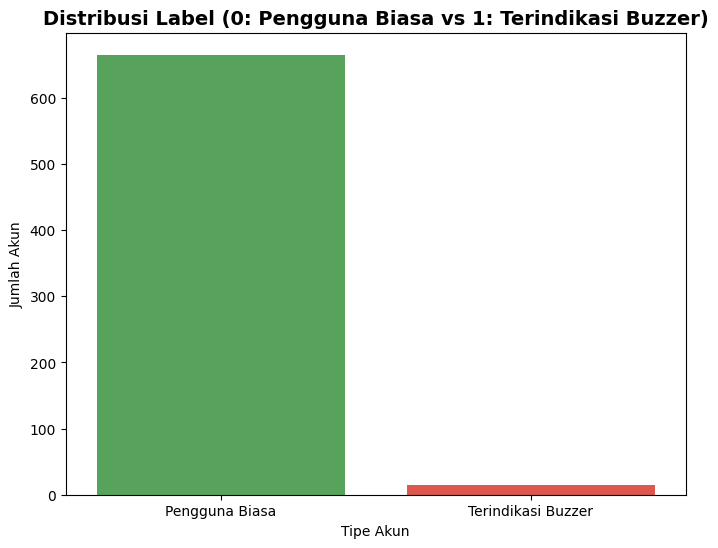


--- Contoh Akun yang Terindikasi Buzzer ---


,username,community,pagerank,betweenness,in_degree,out_degree,narrative_similarity,tweet_frequency,reply_ratio,is_buzzer
200,Juliakango,99,0.000644,0.0,0,5,0.495172,6,0.833333,1
601,renedecrates,70,0.000644,0.0,0,5,0.420386,5,1.000000,1
36,asdiutama,0,0.000644,0.0,0,3,0.504792,3,1.000000,1
578,bayu_irfan24005,213,0.000644,0.0,0,3,0.423521,4,0.750000,1
610,onorus7940,234,0.000644,0.0,0,3,0.547564,4,0.750000,1
21,citystreetlight,11,0.000644,0.0,0,2,0.821278,2,1.000000,1
20,orang_dpr,10,0.000644,0.0,0,2,0.707107,2,1.000000,1
257,Faraz_kepri,123,0.000644,0.0,0,2,0.600526,2,1.000000,1
249,Kingcube12,90,0.000644,0.0,0,2,0.423111,2,1.000000,1
174,MundaPunjaabi,87,0.000644,0.0,0,2,0.707107,2,1.000000,1


In [4]:
if 'is_buzzer' in df_final.columns:
    print("--- 4.4. Labeled Data Distribution ---")
    
    # Menghitung distribusi label
    label_counts = df_final['is_buzzer'].value_counts()
    print(label_counts)

    # Visualisasi distribusi
    plt.figure(figsize=(8, 6))
    sns.countplot(x='is_buzzer', data=df_final, palette=['#4CAF50', '#F44336'])
    plt.title('Distribusi Label (0: Pengguna Biasa vs 1: Terindikasi Buzzer)', fontsize=14, fontweight='bold')
    plt.ylabel('Jumlah Akun')
    plt.xlabel('Tipe Akun')
    plt.xticks([0, 1], ['Pengguna Biasa', 'Terindikasi Buzzer'])
    plt.show()

    # Menampilkan sampel akun yang terindikasi buzzer
    print("\n--- Contoh Akun yang Terindikasi Buzzer ---")
    df_buzzers = df_final[df_final['is_buzzer'] == 1]
    display(df_buzzers.sort_values('out_degree', ascending=False).head(10))

### 4.5. Save Final Labeled Dataset

Langkah terakhir adalah menyimpan DataFrame yang sudah memiliki label ini ke dalam sebuah file CSV baru. File ini akan menjadi input utama untuk Phase 5: Pelatihan Model.


In [5]:
if 'is_buzzer' in df_final.columns:
    # Menyimpan hasil ke file CSV
    df_final.to_csv('labeled_dataset.csv', index=False)
    
    print("\n--- ✅ PHASE 4 COMPLETED ---")
    print("Output: Dataset final dengan label ('labeled_dataset.csv') siap untuk pemodelan.")
else:
    print("\n--- ❌ PHASE 4 FAILED ---")
    print("Kolom 'is_buzzer' tidak berhasil dibuat.")



--- ✅ PHASE 4 COMPLETED ---
Output: Dataset final dengan label ('labeled_dataset.csv') siap untuk pemodelan.
